# Image Inpainting
Image Inpainting se podría traducir como reconstrucción de una imagen. Este proceso consiste en recuperar zonas pérdidas o dañadas de una imagen. Se puede extender también a videos. 
<table>
    <tr>
        <td><img src="images/example7/linc.jpg"></td> 
        <td><img src="images/example7/linc_verde.png"></td>
        <td><img src="images/example7/rec.png"></td>
    </tr>
     <tr>
        <td><img src="images/example11/torre.jpg"></td> 
        <td><img src="images/example11/torre_mask.png"></td>
        <td><img src="images/example11/rec.png"></td>
    </tr>
    <tr>
    <tr>
        <td><img src="images/example10/orange.png"></td> 
        <td><img src="images/example10/orange_mask.png"></td>
        <td><img src="images/example10/rec.png"></td>
    </tr>
    <tr>
        <td><img src="images/example4/Kanizsa_kiwi.png"></td> 
        <td><img src="images/example4/Kanizsa_kiwi_mask.png"></td>
        <td><img src="images/example4/rec.png"></td>
    </tr>
    
 </table>

OpenCV proporciona dos algoritmos de inpainting. El primer algoritmo se basa en el articulo "An Image Inpainting Technique Based on the Fast Marching Method". 
Para explicar este método consideremos la figura siguiente:
![alt](images/esquema_inpainting1.png)
Debemos rellenar el pixel p situado en la frontera $\delta\Omega$ de la region $\Omega$ que debemos rellenar. Para ello tomamos un vecindario de p $B_\epsilon(p)$ de tamaño $\epsilon$ con pixeles que conocemos su valores. El objetivo es dar un valor p a partir de los valores conocidos de los pixeles próximoas a p. Asi el valor que damos a p viene dado por:
$I(p)=\frac{\sum_{q\in B_\epsilon(p)} w(p,q)|I(q)+\nabla I(q)(p-q)| }{\sum_{q\in B_\epsilon(p)} w(p,q)}$. (eq 1)


La funcion peso $w(p,q)$ se diseña para que propague el nivel de gris correcto asi como la forma de los detalles de la imagen. Los pasos generales serían:
* $\delta \Omega_i $= frontera de la region a rellenar
* $\delta \Omega $=$\delta \Omega_i $
* while ($\delta \Omega $ no este vacia)
    *  p = pixel de $\delta \Omega $ mas proximo a $\delta \Omega_i $
    *  rellenar p usando eq 1
    *  avanzar $\delta \Omega $ en $\Omega $

Se itera los pixeles p de  $\delta \Omega $ atendiendo antes los más próximos a  $\delta \Omega_i $. Hay que tener en cuenta que conforma  $\delta \Omega $ avanza en $\Omega $ la frontera se modifica (es decir $\delta \Omega $). Para propagar o hacer avanzar $\delta \Omega $ en $\Omega$ se usa el fast marching method. 

Sea T la distancia de los pixeles in $\Omega$ a la frontera $\delta\Omega$. El algoritmo fast marching method (FMM) procesa los pixeles de $\delta\Omega$ en orden creciente a la distancia a la frontera (T).
Para mayor de talle de este algoritmo se puede consultar:
An Image Inpainting Technique Based on the Fast Marching Method.Alexandru Telea.

OpenCV tiene implementado este método usando el flag cv.INPAINT_TELEA 



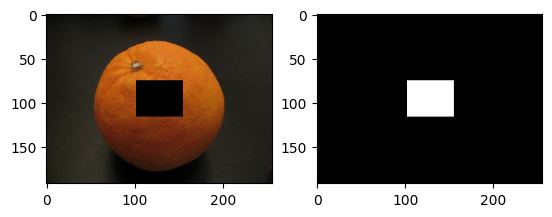

In [11]:
# Ejemplo
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

img = cv.imread("images/example10/orange.png")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread("images/example10/orange_mask.png", cv.IMREAD_GRAYSCALE)
mask = 255 - mask
# mask= cv.cvtColor(mask, cv.COLOR_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.imshow(mask, "gray")


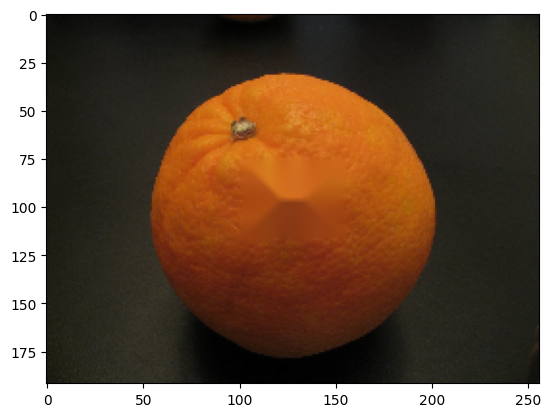

In [12]:
# Aplicamos el proceso de inpainting
rec = cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)
rec = cv.cvtColor(rec, cv.COLOR_BGR2RGB)
plt.imshow(rec)


El segundo algoritmo que tiene implementado OpenCV se basa en el articulo 
**"Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting"** by Bertalmio, Marcelo, Andrea L. Bertozzi, and Guillermo Sapiro in 2001. 
La idea subyacente es usar la dinámica de fluido y ecuaciones diferenciales parciales. En primer lugar usando las aristas se trasmiten los pixeles con valores conocidos a regiones desconcidas. Para poder usar este algoritmo se debe usar en OpenCV el flag cv.INPAINT_NS.


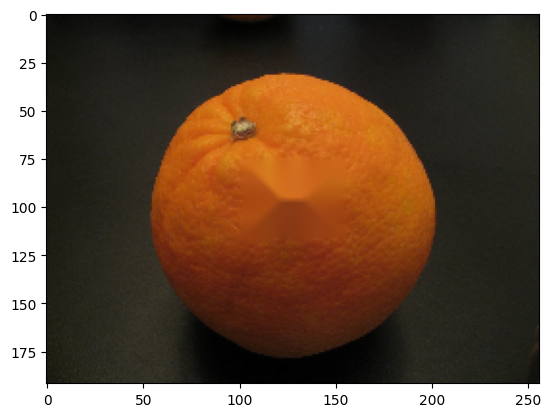

In [13]:
rec2 = cv.inpaint(img, mask, 3, cv.INPAINT_NS)
rec2 = cv.cvtColor(rec2, cv.COLOR_BGR2RGB)
plt.imshow(rec)

## Algoritmo Basado en Parches

El algoritmo que vamos a desarrollar a continuación fue propuesto en **Region Filling and Object Removal by Exemplar-Based Image Inpainting** by A. Criminisi, P. Pérez and K. Toyama. 
La siguiente figura ilustra la idea del algoritmo:
![](esquema_inpainting0.png)
En (a) podemos ver la imagen original, que se compone de una region $\Omega$, su contorno $\delta\Omega$ y la región que esta rellena $\Phi$. En (b) podemos ver un parche centrado en p, $\Psi_p$. Como se puede observar $p \in \delta\Omega$. El objetivo será rellenar el parche $\Psi_p$ de la mejor forma posible.  Como se puede ver en la figura abajo de (a) los mejores candidatos son los parches centrados en $q'$ y $q''$,   $\Psi_{q'}$ y  $\Psi_{q''}$ respectivamente. Como se ve en la figura b abajo el mejor parche se copia en  $\Psi_p$. De esta forma se va reduciendo la region $\Omega$.
![](esquema_inpainting2.png)

Si la  región objetivo es $\Omega$ definimos la región fuente $\Phi=I-\Omega$. Además debemos establecer el tamaño de los parches $\Psi$. Los autores del articulo propusieron un tamaño de $9\times 9$ pixeles.
Además cada pixel tiene un valor de color (si esta en la región fuente o si ha sido ya rellenado , en caso contrario estará vacío) y un valor de confianza, que establece la credibilidad del valor del pixel una vez que ha sido relleno.  Tambien cada pixel que se encuentra en $p \in \delta\Omega$ se define una prioridad 

$P(p)=C(p)D(p)$

siendo $C(p)$ la confianza y $D(p)$ el término data. Asi estos se definen como:

$C(p)=\frac{\sum_{q\in \Psi_p\cap(I-\Omega)}C(q)}{|\Psi_p|}$ (eq1)

$D(p)=\frac{|\nabla I_{p}^{\perp} \cdot n_p|}{\alpha}$ (eq2)


$\alpha$ es una factor de normalización (normalmente puesto a 255). $n_p$ es un vector unidad ortogonal al punto p en la frontera $\delta\Omega$.

En el proceso de inicialización, $C(p)=0 ~\forall p \in \Omega$ y $C(p)=1~\forall p\in I-\Omega$. El término de confianza debe ser entendido como una medida de la cantidad de información creible alrededor del pixel $p$. De esta forma usando C se rellena primero aquellos pixeles rodeados por un mayor de numero de pixels que ya están rellenos (o que son parte de la region fuente).

Una vez establecidas las prioridades para todos los pixeles en $\delta\Omega$, se selecciona el parche $\Psi_p$ con mayor prioridad y lo rellenamos con el mejor parche escogido de $\Phi$.
Para ello se busca un parch $\Phi_q$ que sea mas similar a $\Phi_{\hat{p}}$. De esta forma se escoge:

$\Psi_{\hat{q}}=arg~ min_{\Psi_q \in \Phi} d(\Psi_{\hat{p}},\Psi_q)$


donde la distancia $ d(\Psi_{\hat{p}},\Psi_q)$ es simplemente la suma de las diferencias cuadradas de los pixeles ya rellenos en los parches. 

Despues que el parch $\Psi_{\hat{p}}$ se rellena con los nuevos valores, el valor de confianza $C(p)$ se modifica con 
$C(p)=C(\hat{p}) ~~\forall p \in \Psi_{\hat{p}}\cap\Omega$. 


Por lo tanto el algoritmo realiza los siguientes pasos:
* Definir la region a rellenar y obtener el contorno $\delta \Omega$
* Calcular las prioridades $P(p) ~~\forall p \in \delta\Omega^t$
* Encontrar el parche $\Psi_{\hat{p}}$ con mayor prioridad
* Encontrar el parche $\Psi_{\hat{q}}$ que minimiza $d(\Psi_{\hat{p}},\Psi_q)$
* Copiar $\Psi_{\hat{q}}$ en $\Psi_{\hat{p}}$
* Modificar $C(p) ~\forall p \in \Psi_{\hat{p}}\cap\Omega$





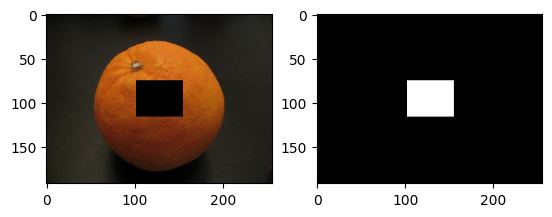

In [14]:
# leemos las imagenes y obtener Omega y dOmega
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

img = cv.imread("images/example10/orange.png")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread("images/example10/orange_mask.png", cv.IMREAD_GRAYSCALE)
mask = (255 - mask) / 255

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.imshow(mask, "gray")


In [15]:
# codigo
from inpainting_Criminisi.inpainter import Inpainter

output_image = Inpainter(img, mask, patch_size=6, plot_progress=0).inpaint()
cv.imwrite("orange_fill.png", output_image)


Time to find best: 0.560676 seconds
46985 of 49152 completed
Time to find best: 0.503529 seconds
46991 of 49152 completed
Time to find best: 0.502804 seconds
46997 of 49152 completed
Time to find best: 0.504272 seconds
47003 of 49152 completed
Time to find best: 0.534303 seconds
47009 of 49152 completed
Time to find best: 0.632467 seconds
47015 of 49152 completed
Time to find best: 0.557914 seconds
47021 of 49152 completed
Time to find best: 0.484656 seconds
47027 of 49152 completed
Time to find best: 0.481514 seconds
47033 of 49152 completed
Time to find best: 0.477786 seconds
47039 of 49152 completed
Time to find best: 0.478956 seconds
47045 of 49152 completed
Time to find best: 0.478323 seconds
47051 of 49152 completed
Time to find best: 0.477766 seconds
47057 of 49152 completed
Time to find best: 0.481364 seconds
47063 of 49152 completed
Time to find best: 0.484353 seconds
47069 of 49152 completed
Time to find best: 0.486064 seconds
47075 of 49152 completed
Time to find best: 0.492

True

images/example8


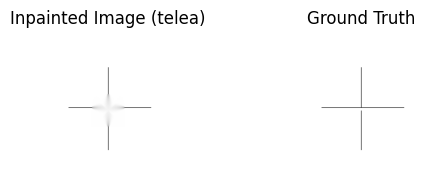

images/example7


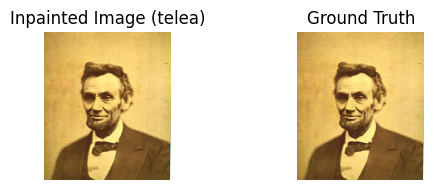

images/example11


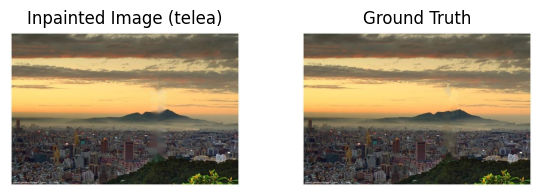

images/example5


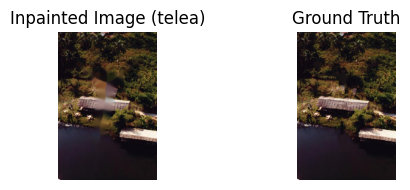

images/example13


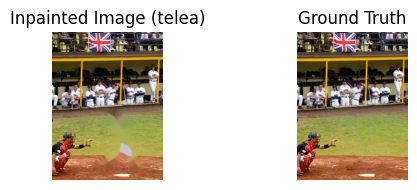

images/example14


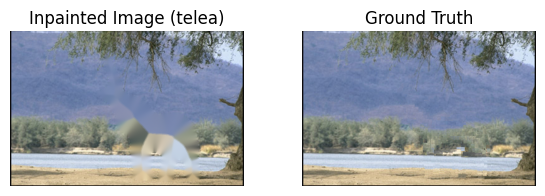

images/example1


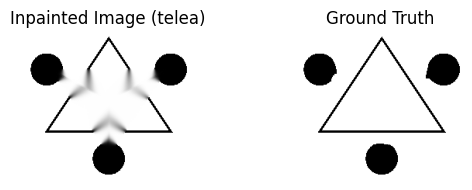

images/example10


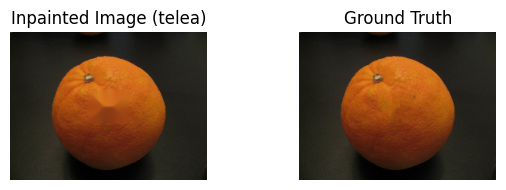

images/example2


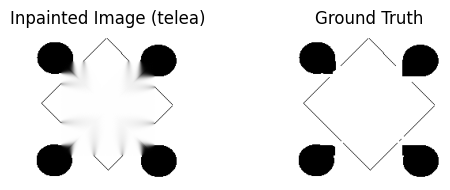

images/example4


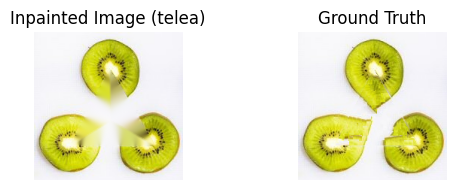

images/example6


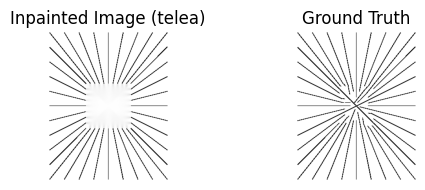

images/example3


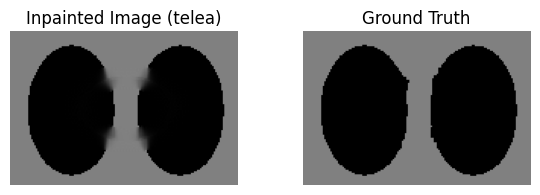

images/example15


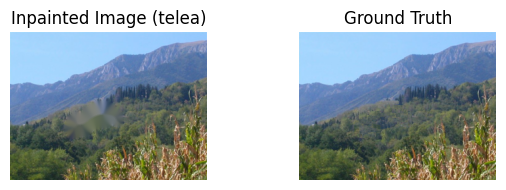

images/example9


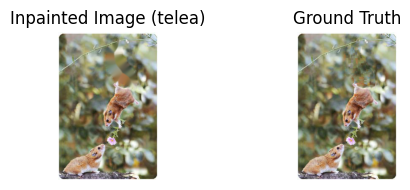

images/example8


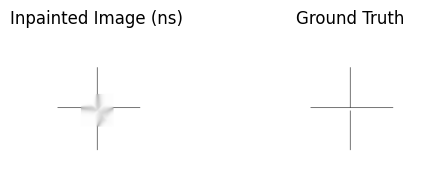

images/example7


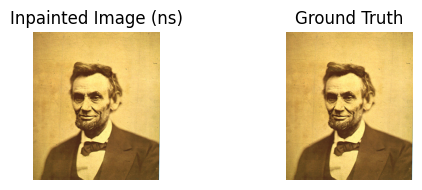

images/example11


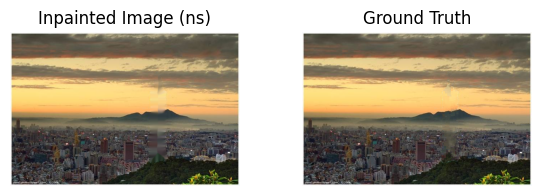

images/example5


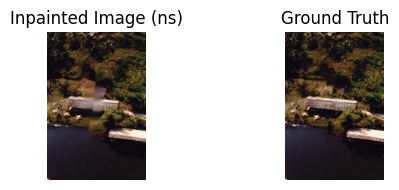

images/example13


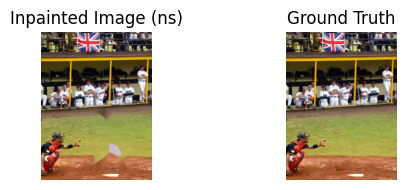

images/example14


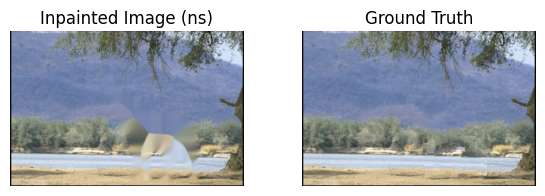

images/example1


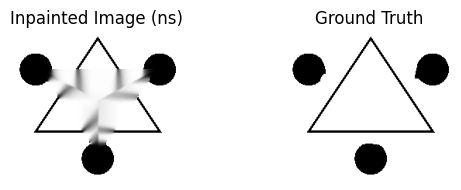

images/example10


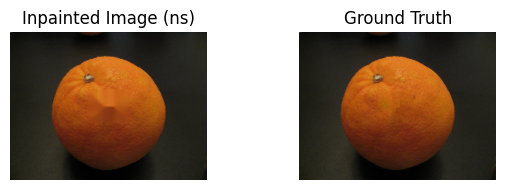

images/example2


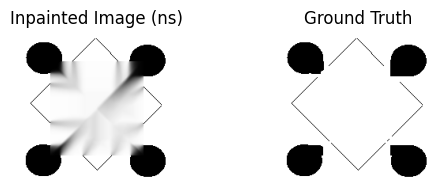

images/example4


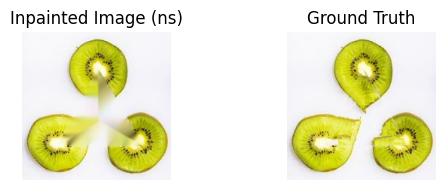

images/example6


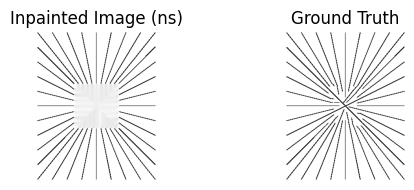

images/example3


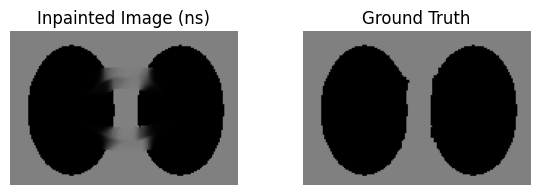

images/example15


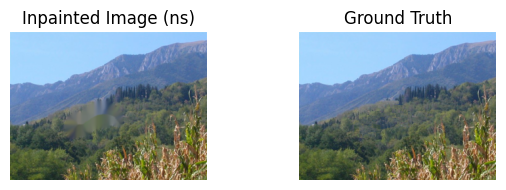

images/example9


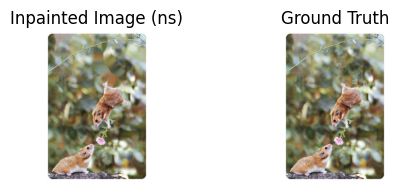

MSE using TELEA: 6.347850372583358
MSE using NS: 8.984485348374367


In [17]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np


def make_impaint(method: str):
    images_path = "images"
    if method == "ns":
        method_flag = cv2.INPAINT_NS
    else:
        method_flag = cv2.INPAINT_TELEA

    mse = []

    for path in os.listdir(images_path):
        examples_path = os.path.join(images_path, path)
        if "esquema" not in examples_path:
            for filename in os.listdir(examples_path):
                if (
                    "mask" not in filename
                    and "rec.png" not in filename
                    and "avi" not in filename
                    and "1" not in filename
                    and "verde" not in filename
                ):
                    filepath = os.path.join(examples_path, filename)
                    img = cv2.imread(filepath)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    print(examples_path)
                    mask_path = [
                        os.path.join(examples_path, f)
                        for f in os.listdir(examples_path)
                        if "mask" in f or "1" in f or "verde" in f
                    ][0]
                    mask_color = cv2.imread(mask_path)

                    lower_green = np.array([0, 200, 0])
                    upper_green = np.array([50, 255, 50])
                    mask = cv2.inRange(mask_color, lower_green, upper_green)

                    if examples_path == "images/example10":
                        # Este ejemplo usa una máscara negra en vez de verde, hay que hardcodearlo
                        lower_black = np.array([0, 0, 0])
                        upper_black = np.array([50, 50, 50])
                        mask = cv2.inRange(mask_color, lower_black, upper_black)

                    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

                    correct_img = cv2.imread(os.path.join(examples_path, "rec.png"))
                    correct_img = cv2.cvtColor(correct_img, cv2.COLOR_BGR2RGB)

                    rec = cv2.inpaint(img, mask, 3, method_flag)

                    # Display results
                    plt.figure(figsize=(6, 2))

                    # Inpainted Image
                    plt.subplot(1, 2, 1)
                    plt.imshow(rec)
                    plt.title(f"Inpainted Image ({method})")
                    plt.axis("off")

                    # Ground Truth
                    plt.subplot(1, 2, 2)
                    plt.imshow(correct_img)
                    plt.title("Ground Truth")
                    plt.axis("off")

                    plt.tight_layout()
                    plt.show()
                    mse.append(np.mean((correct_img - rec) ** 2))
    return np.mean(mse)


mse_telea = make_impaint("telea")
mse_ns = make_impaint("ns")
print(f"MSE using TELEA: {mse_telea}")
print(f"MSE using NS: {mse_ns}")

- El último método me tarda muchísmo tiempo en mi ordenador, no puedo ejecutarlo para todas las imágenes.

### EJERCICIO

Sobre las imágenes dadas (example1 a example15) aplicar los tres procedimientos de inpainting. Suponed que la imagen correcta es la imagen rec dada en cada directorio. Medir el error cuadrado medio del resultado que obtiene cada procedimiento de inpainting con la imagen rec dada en cada ejemplo.

 Mostrar gráficas y tablas que comparen los métodos y establezcer el mejor método. 
